## Loan Default Prediction: A Practice Data Take-Home Challenge

This practice data take-home challenge was originally presented by [Benjamin Obi Tayo, Ph.D.](https://benjaminobi.medium.com/), who implemented a Monte Carlo simulation in R to solve it (you can find his solution and the dataset on [Github](https://github.com/bot13956/Monte_Carlo_Simulation_Loan_Status)). The Monte Carlo approach was seemingly not satisfactory, according to Benjamin's account [here](https://benjaminobi.medium.com/i-failed-my-data-science-interview-51e1fc20170c). A fellow scientist commented there that this problem is a textbook case of [Survival Analysis](https://towardsdatascience.com/survival-analysis-intuition-implementation-in-python-504fde4fcf8e), a statistical method of which I was previously unaware.

In this notebook, I show an alternative method of extrapolation via curve fitting in order to solve the business problem of prediction the probability of loan charge-off based on data for prior loans. I've implemented the solution in Python, and while I didn't solve the problem in one spurt (as might be expected in some take-home challenge formats), I'd say the estimate of 3-6 hours that the company gave was certainly fair.

### Introduction and Problem Statement

Predicting the status of a loan is an important problem in risk assessment. A bank or financial organization has to be able to estimate the risk involved before granting a loan to a customer. Data Science and predictive analytics play an important role in building models that can be used to predict the probability of loan default.

In this project, we are provided with a data set loan_timing.csv containing 50000 data points. Each data point represents a loan, and two features are provided as follows:
- The column with header “days since origination” indicates the number of days that elapsed between origination and the date when the data was collected.
- For loans that charged off before the data was collected, the column with header “days from origination to charge-off” indicates the number of days that elapsed between origination and charge-off. For all other loans, this column is blank.

**Project Objective:** The goal of this project is to use techniques of data science to estimate what fraction of these loans will have charged off by the time all of their 3-year terms are finished.

### Initial Thoughts

Since we're given some data to work with which is presumably crucial to the task at hand, we'll look into that briefly before consdering the solution structure and how to tackle this problem.

### Loading the data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
loan_df = pd.read_csv('data/loan_timing.csv')

In [3]:
loan_df.dtypes

days since origination                  int64
days from origination to chargeoff    float64
dtype: object

In [4]:
loan_df.head(15)

,days since origination,days from origination to chargeoff
0,109,NaN
1,679,NaN
2,723,NaN
3,509,NaN
4,254,NaN
5,158,NaN
6,302,NaN
7,143,NaN
8,354,NaN
9,438,NaN


In [5]:
loan_df.shape

(50000, 2)

In [6]:
loan_df.describe()

,days since origination,days from origination to chargeoff
count,50000.000000,3305.000000
mean,365.844760,214.852345
std,210.965114,165.233874
min,0.000000,0.000000
25%,183.000000,76.000000
50%,366.000000,180.000000
75%,549.000000,323.000000
max,730.000000,725.000000


array([[<AxesSubplot:title={'center':'days since origination'}>,
        <AxesSubplot:title={'center':'days from origination to chargeoff'}>]],
      dtype=object)

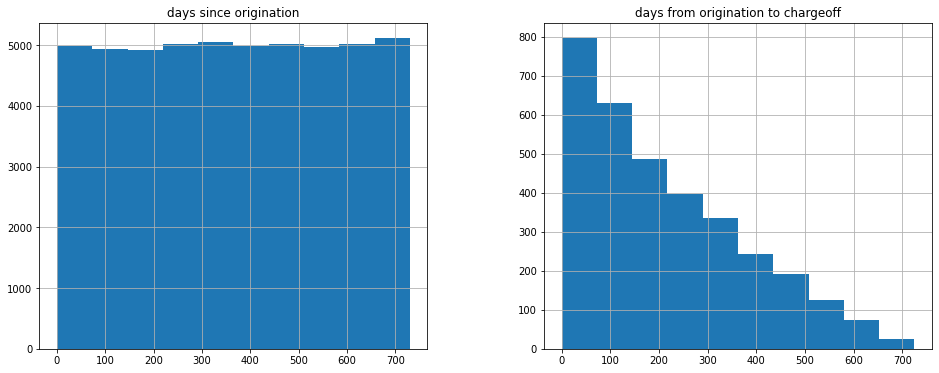

In [7]:
loan_df.hist(figsize = (16,6))

Note that:
- The max days since origination equates to two years, meaning that for all loans we have **at least** a year to go in order to make it to the required three.
- There are 3305 chargeoffs out of 50000 loans, which is 6.61%.
- Most chargeoffs happen pretty quickly! The mean is about seven months, and the mode is earlier still. The chances of a loan being charged-off decreases with time, which makes sense - if a loan lasted for a while, it's easier to assume that it's being repaid on schedule.

### Problem Formulation and Brainstorming

It seems this problem splits into two challenges.

The first is straightforward: we have data on loans which are up to two years since origination, so we should be able to take the loans still outstanding and use that data to predict if and when they'll default - up until two years since origination.

The second and more interesting challenge stems from the fact that we don't have any data about loans which are more than two years old. Barring access to external data sources, it appears we'll have to extrapolate the charge-off probability from the data we have, meaning that we must extend the distribution presented above ("days from origination until chargeoff") in order to extrapolate charge-off probability for loans above two years. This must be done **first**, otherwise the prediction is ineffective.

We therefore need to:
1. Fit a regression model to the days until charge-off in order to create a probability function for charge-off as a function of time, p(t).
2. Translate that into a cumulative probablity function for failure after time t, p(t>T). 
3. Apply that function for every loan left outstanding, based on the "time since origination" feature, which we'll mark as T.  

### Step 1: finding p(t)

A more detailed look at the distribution:

<AxesSubplot:>

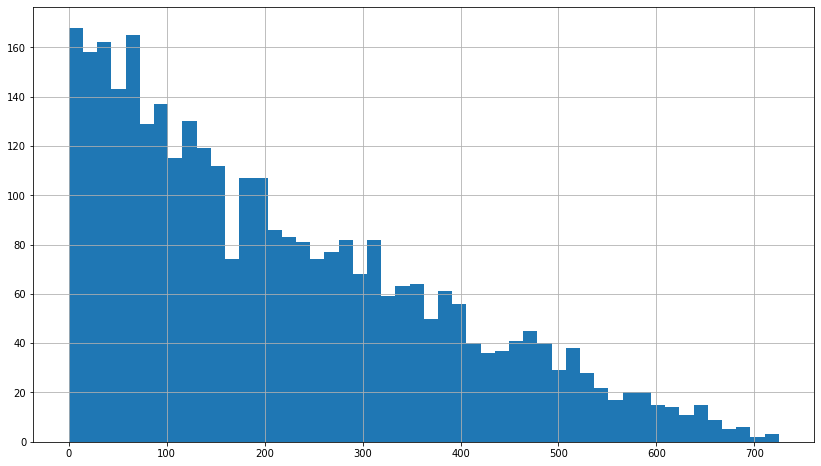

In [8]:
loan_df["days from origination to chargeoff"].hist(bins = 50,figsize = (14,8))

Taking a look at a few popular distributions, this seemto math the description of an exponential decay function, $$ f(t) = a\cdot e^{-bt} + c $$

We can use the SciPy curve_fit tool to try and best determine these parameters. Let's begin by plotting the probability that a charge-off will be issued on a given day since loan origination:

Text(0, 0.5, 'T (in days)')

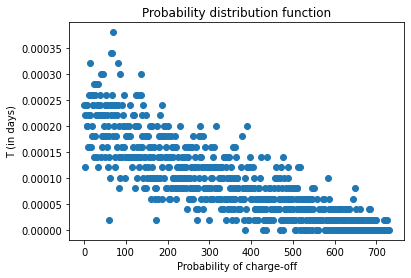

In [9]:
x = np.linspace(1.0, 730.0, num=730)
y = np.asarray([sum(loan_df["days from origination to chargeoff"] == int(num))/50000 for num in x])
# count the number of occurences and divide by 50000.

fig, ax = plt.subplots() 
ax.scatter(x, y, label='Raw data')
ax.set_title('Probability distribution function')
ax.set_xlabel('Probability of charge-off')
ax.set_ylabel('T (in days)')

We can now use the curve fit tool in order to find the optimal coefficients for the exponential curve:

In [10]:
from scipy.optimize import curve_fit

# We need to provide an initial guess:
a = 1.5
b = 0.5 # Must be positive, since we want a decay exponent (the function already contains a mimus).
c = 0.00025   # Seems to be where the curve would hit the axis.

# Fit the function a * np.exp(-b * t) + c to x and y
best_fit, covar = curve_fit(lambda t, a, b, c: a * np.exp(-b * t) + c, x, y)
# From the covariance matrix's diagonals we can calculate 
sigma = np.sqrt(np.diagonal(covar))

We can now extract the ideal (= least R^2) coefficeints a,b,c. Note that in addition to the best fit, we also get a covariance matrix from which a confidence interval (in this case, one sigma's worth) can be calculated. We'll leave this aside for now in the name of simplicity, but I'll briefly discussed how uncertainly comes into play at the very end of this notebook.

In [11]:
# an easy way to properly format parameter errors
from uncertainties import ufloat
a = best_fit[0]
b = best_fit[1]
c = best_fit[2]

a_text = ufloat(best_fit[0], sigma[0])
b_text = ufloat(best_fit[1], sigma[1])
c_text = ufloat(best_fit[2], sigma[2])

text_res = "Best fit parameters:\na = {}\nb = {}\nc = {}".format(a_text, b_text, c_text)
print(text_res)

Best fit parameters:
a = 0.000297+/-0.000016
b = 0.00204+/-0.00025
c = (-6.4+/-1.9)e-05


We can now plot the curve alongside the raw data:

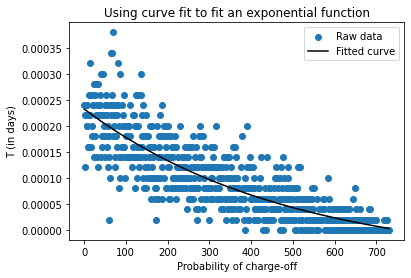

In [12]:
x_fitted = np.linspace(np.min(x), np.max(x), 730)
y_fitted = a * np.exp(-b * x_fitted) + c

# Plot
ax = plt.axes()
ax.scatter(x, y, label='Raw data')
ax.plot(x_fitted, y_fitted, 'k', label='Fitted curve')
ax.set_title('Using curve fit to fit an exponential function')
ax.set_xlabel('Probability of charge-off')
ax.set_ylabel('T (in days)')
ax.legend()

We can now expand the fitted curve to apply for three years instead of two:

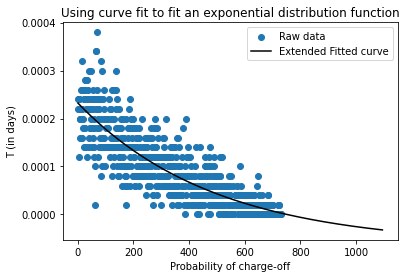

In [13]:
x_fitted = np.linspace(1, 1095, 1095) # 3*365
y_fitted = a * np.exp(-b * x_fitted) + c

# Plot
ax = plt.axes()
ax.scatter(x, y, label='Raw data')
ax.plot(x_fitted, y_fitted, 'k-', label='Extended Fitted curve')
ax.set_title('Using curve fit to fit an exponential distribution function')
ax.set_xlabel('Probability of charge-off')
ax.set_ylabel('T (in days)')
ax.legend()

We notice a not-so-slight issue: the probability distribution goes negative, which is mathmatically impossible. We can solve the equation for the above parameters (on WolframAlpha) and find that the function becomes less than zero after 751 days, so we'll replace all of the indexes after that day to be zero:  

In [14]:
y_fitted[751:] = 0

### Step 2: the cumulative function p(t>T)

We now ask ourselves: what is the probability that a loan will be charged-off AFTER a given time T? This will allow us to take the outstanding loans we have and determine how many of them are likely to be charged-off in the future.

In statistics, this term is called the Complementary Cumulative Distribution Function (CCDF).

In [15]:
y_prob_chargeoff_after_T = np.asarray([sum(y_fitted[index:]) for index in range(len(y_fitted))])
y_prob_chargeoff_after_T

array([0.06580938, 0.06557734, 0.0653459 , ..., 0.        , 0.        ,
       0.        ])

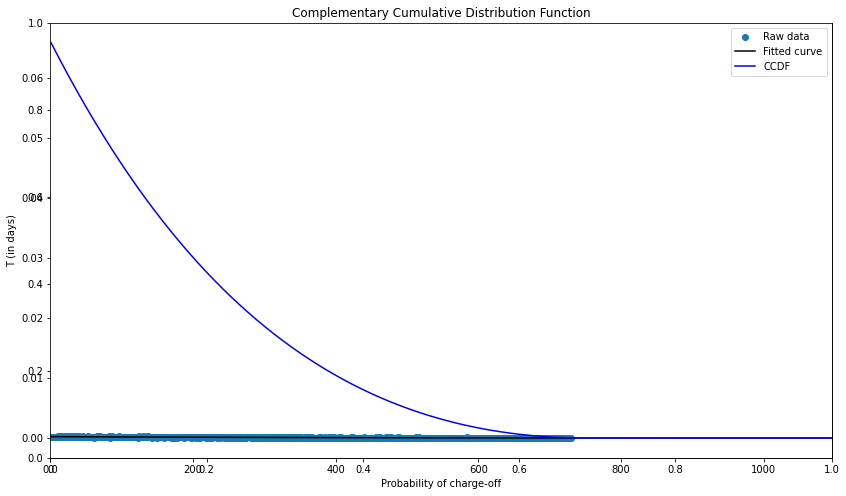

In [16]:
# Plot
fig, ax = plt.subplots(figsize = (14,8)) 
ax = plt.axes()
ax.scatter(x, y, label='Raw data')
ax.plot(x_fitted, y_fitted, 'k', label='Fitted curve')
ax.plot(x_fitted, y_prob_chargeoff_after_T, 'b', label='CCDF')
ax.set_title('Complementary Cumulative Distribution Function')
ax.set_xlabel('Probability of charge-off')
ax.set_ylabel('T (in days)')
ax.set_xlim(0, 1095)
ax.legend()

This cumulative graph makes sense: at time T = 0 we see that charge-off is slightly higher than the value of 6.61% we mentioned earlier, since we've modeled some extra probablity that the loan might be written off in the beginning of year 3.

### Step 3: Making the Prediction

Now we just need to apply our cumulative probability function to the data we have regarding the remaining loans since origination, to determine how many will make it.

In [17]:
outstanding_loans = loan_df[np.isnan(loan_df["days from origination to chargeoff"])]["days since origination"]

In [18]:
prob_chargeoff_outstanding = [y_prob_chargeoff_after_T[int(loan)] for loan in outstanding_loans]

In [19]:
out_df = pd.DataFrame(zip(outstanding_loans, prob_chargeoff_outstanding))
out_df.columns = ['Days Since Origination', 'Probability of Charge-off']
out_df

,Days Since Origination,Probability of Charge-off
0,109,0.043823
1,679,0.000357
2,723,0.000052
3,509,0.004545
4,254,0.023320
...,...,...
46690,253,0.023432
46691,664,0.000526
46692,209,0.028759
46693,214,0.028116


All that's left to do is to average the probabilities above in order to find the percentage of oustanding loans which will likely be charged-off:  

In [20]:
out_df['Probability of Charge-off'].mean()

0.020052089037144387

**Bottom line: Two percent** of outstanding loans are likely to be charged-off, bringing the grand total (including the loans which have already been charged-off) to **8.615%**.

### Summary

Using curve fitting, we were able to create a distribution function which was able to tell us the probablity that a loan would fail (be charged off) on a given day, and AFTER a given day. By applying this function to the data we have on outstanding loans, we we're able to determine that an additional two percent of loans are likely to be written off.

This has tremendous business value for the company, which will be better prepared for the losses they're likely to incur due to those defaults. 

### Extra Credit: Dealing With Uncertainty

The first step of the solution involved finding the exponential function with the best coefficients to fit the data (meaning with the lowest R^2 score). Utilizing that curve allowed us to ultimately come up with our final answer, but in the real world there is statistical uncertainty which would need to be modeled into the solution. As in, rather than predicting a charge-off rate of 2% for the remaining loans, we'd provide a range which would account for, say, 95% of the possible outcomes.

An excellent [answer](https://stackoverflow.com/questions/39434402/how-to-get-confidence-intervals-from-curve-fit) on Stack Overflow by [Vlas Sokolov](https://stackoverflow.com/users/4118756/vlas-sokolov) details how to calculate and visualize the confidence bounds for a fitted curve. In order to properly solve our problem, instead of following the steps outlined above for the "ideal" curve, we'd need to repeat the process for the upper and lower boundary curves as well. Solving the problem for both the upper and lower curves would give us the range of charge-off rates which would be a much more robust way of solving the problem and presenting the possibilities to executives.

(If you do read the Stack Overflow answer, note that we'd be using the so-called "quick and wrong" solution that Vlas presents, since we don't have the error distribution for the data, only a count of how many loans were charged-off on a given day since origination.) 